# Board Game Explorer
The aim of this notebook is to explore popular board games, and recommend new board games based on a game that a user already likes.

This notebook imports data on the top 500 ranked games from http://www.boardgameatlas.com, structures the data into a usable format and cleans the data. It performs exploratory data analysis of this dataset, and then implements a K-nearest-neighbor model that will be used to implement the board game recommendation system.

# Notebook structure
1. Pull data from boardgameatlas.com API
2. Wrangle data into dataframe for further analysis
    - Implement one-hot encoding for categorical variables
    - Scrape game category names from linked webpages
3. Initial EDA
    - Distribution of game category labels in this dataset
    - Distribution of publishers in this dataset
4. Data cleaning
5. Exploring correlations between variables
6. Implementing K-nearest neighbor model for use in recommendation system
7. Save data and model output
8. Use model to build a recommendation system, and implement as a Dash app.

In [2]:
## Pull user data on a list of board games from BoardGameAtlas.
## Since the API can only return 100 games at a time, we will get the data in chunks of 100
## We will take 500 games in total
import requests
response = requests.get("https://api.boardgameatlas.com/api/search?order_by=rank&ascending=false&pretty=true&limit=100&client_id=dbgsb4HN3A")
#Put this data (dict) into a variable BoardGameData
BoardGameData = response.json()
BoardGameList = BoardGameData['games']
# Now do this again 4 times
for x in [100,200,300,400]:
    response = requests.get("https://api.boardgameatlas.com/api/search?order_by=rank&ascending=false&pretty=true&skip="+str(x)+"&limit=100&client_id=dbgsb4HN3A")
    BoardGameData = response.json()
    BoardGameList = BoardGameList + BoardGameData['games']
print('Number of games in this dataset: ')
print(len(BoardGameList))
# Print a list of the available keys
print('Keys in this dataset include: ')
print(list(BoardGameList[0].keys()))

Number of games in this dataset: 
500
Keys in this dataset include: 
['id', 'handle', 'url', 'bga_edit_url', 'template_url', 'name', 'price', 'price_ca', 'price_uk', 'price_au', 'msrp', 'msrps', 'discount', 'year_published', 'min_players', 'max_players', 'player_counts', 'min_playtime', 'max_playtime', 'min_age', 'description', 'commentary', 'faq', 'thumb_url', 'image_url', 'matches_specs', 'specs', 'mechanics', 'categories', 'publishers', 'designers', 'primary_publisher', 'primary_designer', 'developers', 'related_to', 'related_as', 'artists', 'names', 'rules_url', 'amazon_rank', 'official_url', 'comment_count', 'num_user_ratings', 'average_user_rating', 'weight_amount', 'weight_units', 'size_height', 'size_depth', 'size_units', 'historical_low_prices', 'active', 'num_user_complexity_votes', 'average_learning_complexity', 'average_strategy_complexity', 'visits', 'lists', 'mentions', 'links', 'plays', 'rank', 'type', 'sku', 'upc', 'isbn', 'video_links', 'availability_status', 'num_dist

BoardGameList is a list of 500 games. For each game, there is a dict with data for each field as defined by the keys above.

Most fields are either strings (eg. 'id') or floats (e.g. 'price'). However, some contain dicts (e.g. 'category').


Our variables of interest will be:

`handle`: the name of the game


`min_playtime` and `max-playtime`: the minimum and maximum playtime of the game

`num_user_ratings`: the number of users who have rated this game on BoardGameAtlas

`average_user_rating`: the average rating of this game on BoardGameAtlas

`average_learning_complexity`: the average user rating of how difficult it is to learn to play this game

`num_user_complexity_votes`: the number of users who have rated the difficulty of learning this game

`min_age`: the minimum recommended player age for this game

`primary_publisher`: the main publisher of this game

`categories`: the category labels assigned to this game

In [4]:
#To enable handling of the data, we will convert it into a dataframe format.
import pandas as pd
import numpy as np
#Define the variables we are interested in from the keys listed above
SimpleFields = ['handle','min_playtime','max_playtime','num_user_ratings','average_user_rating',
                'average_learning_complexity','num_user_complexity_votes','min_age']
#These keys are different because they contain dicts, so we need to extract the keys of interest from each dict
SpecialFields = ['primary_publisher']

#Loop through each game and save variables to dataframe
Games_df = pd.DataFrame([],columns=SimpleFields+SpecialFields)
for Game in BoardGameList:
    #note: some games are missing the "publisher" field, so we will skip these games
    if Game['primary_publisher'] != {}:
        #save value of each field for this game to a variable
        ThisGame = []
        for Field in SimpleFields:
            ThisGame.append(Game[Field])
        #now add the name of the publisher, since this field is a dict and requires extra parsing
        ThisGame.append(Game['primary_publisher']['name'])
        #now add this game to the Games dataframe
        Games_df.loc[Game['id']] = ThisGame

In [5]:
## In the original data, categories are defined by an ID# and a URL
## On this webpage is the category name. So let's scrape the category names from the URL
from urllib.request import urlopen
# Put category IDs and names into a Series
category_names = pd.Series(dtype='object')
n_unknown = 0
# loop through games
for game in BoardGameList:
    for cat in game['categories']:
        # only add this category to the list if it is not already there
        if cat['id'] not in category_names.index:
            try:
                page = urlopen(cat['url'])
            # if the URL doesn't work, put an "unknown" label with a number
            # (so it is still distinct from other unknown category labels)
            except:
                n_unknown = n_unknown+1
                category_names[cat['id']] = 'unknown'+str(n_unknown)
            else:
                # Get the html from this webpage as a string
                html_bytes = page.read()
                html = html_bytes.decode("utf-8")
                #the category name always comes right after the first instance of "<title>"
                title_to_end = html[html.find("<title>")+7:]
                #and is followed by " | Board Game Atlas"
                category_names[cat['id']] = title_to_end[:title_to_end.find(" | Board Game Atlas")]



In [6]:
## Now use one-hot encoding for categories.
## First, create the encoding labels
Category_Encoding_Labels = ['Category_'+i for i in category_names.values]

Game_Categories = pd.DataFrame([],columns=Category_Encoding_Labels) # to store category encodings for each game
## Because a single game can belong to multiple categories, we will do this game by game 
for Game in BoardGameList:
    # For this game, set all categories to zero by default
    Game_Categories.loc[Game['id']] = np.zeros(len(Category_Encoding_Labels),dtype='int8')
    # Then loop through the category labels for this game, and put a 1 in the corresponding columns
    for cat in Game['categories']:
        Game_Categories.loc[Game['id']]['Category_'+category_names[cat['id']]] = 1

# Now concatenate the one-hot encoded category fields onto the Games dataframe
Games_df = pd.concat([Games_df,Game_Categories],axis=1)

In [7]:
## Check that all categories have at least one game (i.e. columns with <1 entry)
Game_Categories.columns[Game_Categories.sum()<1]

Index([], dtype='object')

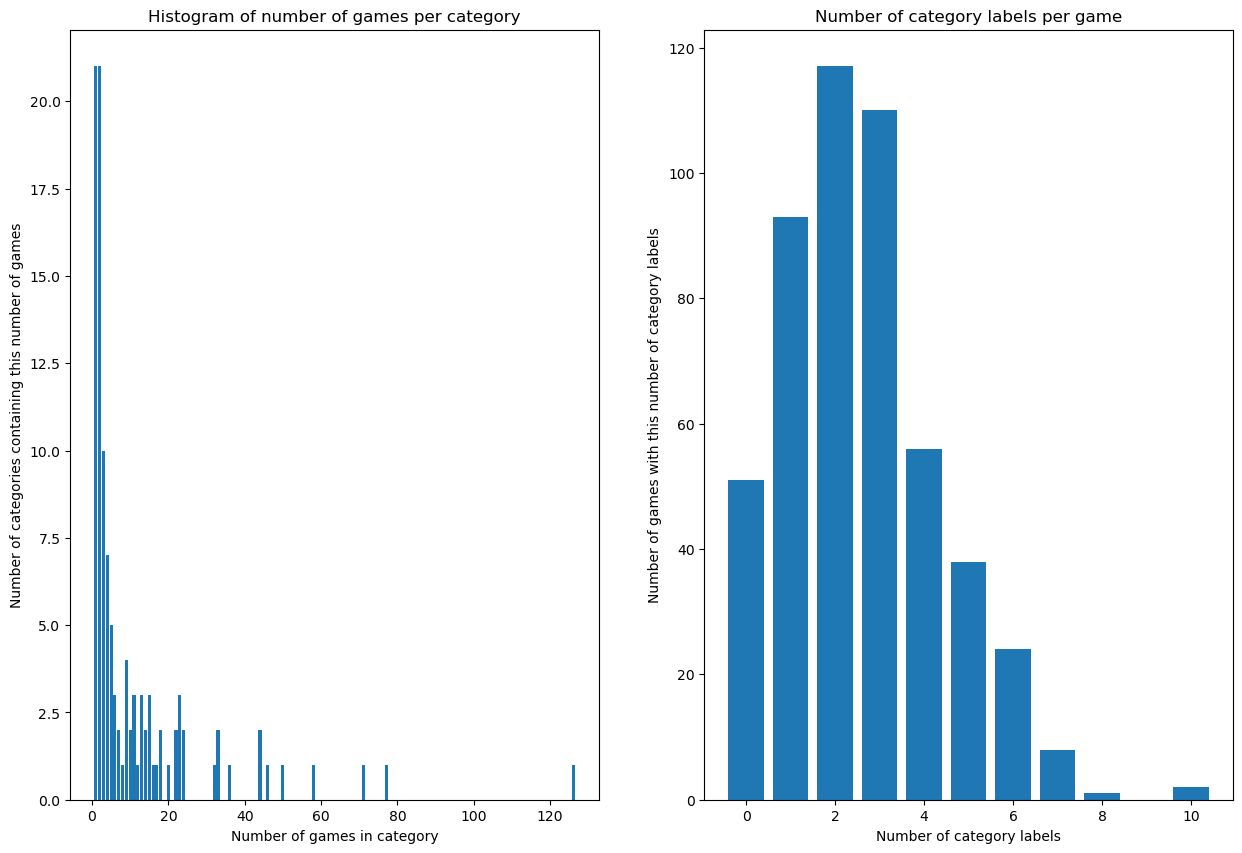

In [8]:
## Plot a histogram of the number of games per category
import matplotlib.pyplot as plt
SortedCats = Game_Categories.sum().sort_values(ascending=False)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[15,10])
CatOccurrences = list(set(SortedCats))
CatOccFrequencies = [np.sum(SortedCats == i) for i in CatOccurrences]
ax1.bar(CatOccurrences,CatOccFrequencies)
ax1.set_ylabel('Number of categories containing this number of games')
ax1.set_xlabel('Number of games in category')
ax1.set_title('Histogram of number of games per category');

## Also plot the number of categories for each game
NumCats = Game_Categories.sum(axis=1).sort_values(ascending=False)
NumOccurrences = list(set(NumCats))
NumOccFrequencies = [np.sum(NumCats == i) for i in NumOccurrences]
ax2.bar(NumOccurrences,NumOccFrequencies)
ax2.set_ylabel('Number of games with this number of category labels')
ax2.set_xlabel('Number of category labels')
ax2.set_title('Number of category labels per game');

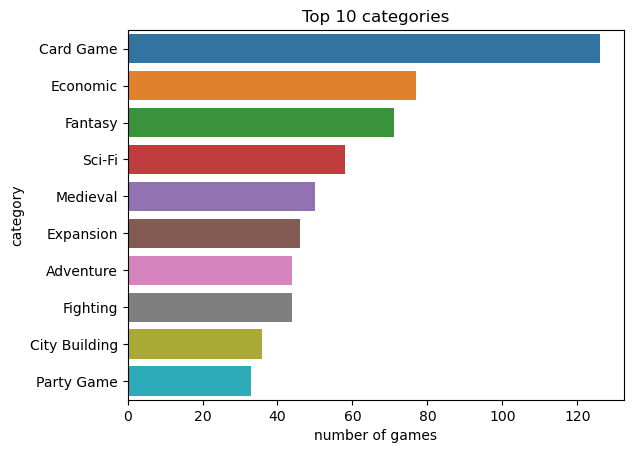

In [9]:
## Most categories contain <10 games, but there are a few categories containing >40 games
## Most games have 0-5 category labels, but a subset have more. The maximum number of
## category labels is 10.

## Let's plot the top 10 categories
# Get the names of the top 10 categories (without the prefix)
Top10CatNames = []
for cat in SortedCats[0:10].index:
    Top10CatNames.append(cat[cat.find('_')+1:len(cat)])
# And plot as barplot
import seaborn as sns
ax = sns.barplot(x=SortedCats[0:10].values,y=Top10CatNames)
ax.set_ylabel('category')
ax.set_xlabel('number of games')
ax.set_title('Top 10 categories');

In [10]:
## Let's also use one-hot encoding for the publisher data
## First check how many unique publishers we have
len(set(Games_df['primary_publisher']))

172

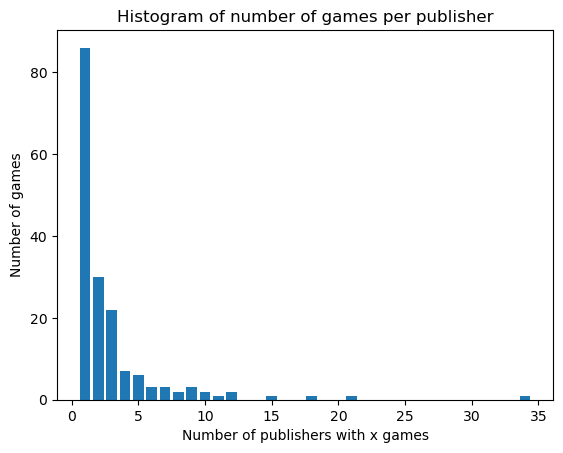

In [11]:
## Now let's implement one-hot encoding
Publisher_dummies = pd.get_dummies(Games_df['primary_publisher'],prefix='Publisher')
## Drop the publisher column, and replace with the one-hot encoded version
Games_df = Games_df.drop('primary_publisher',axis=1)
Games_df = pd.concat([Games_df,Publisher_dummies],axis=1)

## Let's plot the number of games from each publisher
fig,ax = plt.subplots(1,1)
SortedPubs = Publisher_dummies.sum().sort_values(ascending=False)

PubOccurrences = list(set(SortedPubs))
PubOccFrequencies = [np.sum(SortedPubs == i) for i in PubOccurrences]

ax.bar(PubOccurrences,PubOccFrequencies)
ax.set_ylabel('Number of games')
ax.set_xlabel('Number of publishers with x games')
ax.set_title('Histogram of number of games per publisher');

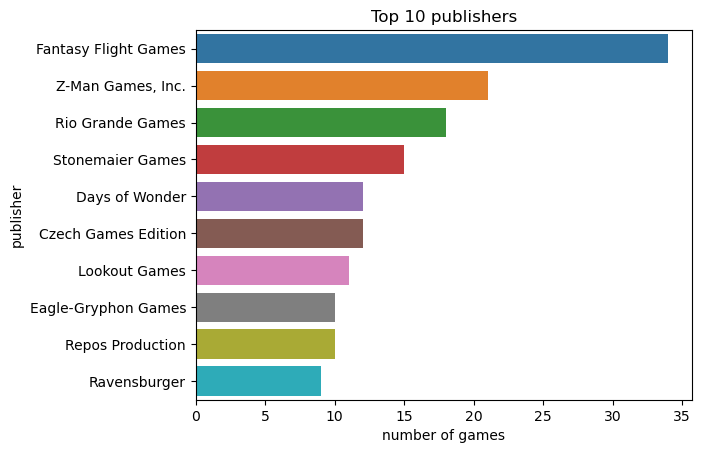

In [12]:
## Most publishers have just 1-3 games in the dataset, but a small number of publishers have 10 or more games.
## Let's look at the top 10 publishers:
# Get the names of the top 10 publishers (without the prefix)
Top10PubNames = []
for pub in SortedPubs[0:10].index:
    Top10PubNames.append(pub[pub.find('_')+1:len(pub)])
import seaborn as sns
ax = sns.barplot(x=SortedPubs[0:10].values,y=Top10PubNames)
ax.set_ylabel('publisher')
ax.set_xlabel('number of games')
ax.set_title('Top 10 publishers');

In [13]:
## Now we will check the description of the data
Games_df.describe()

,min_playtime,max_playtime,num_user_ratings,average_user_rating,average_learning_complexity,num_user_complexity_votes,Category_Adventure,Category_Animals,Category_Asymmetric,Category_4x,...,Publisher_WizKids,Publisher_Wizards of the Coast,Publisher_Wonder Forge,"Publisher_Z-Man Games, Inc.",Publisher_Zoch Verlag,Publisher_alea,Publisher_dV Giochi,Publisher_daVinci Games,Publisher_dlp games,Publisher_eggertspiele
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,51.412121,83.210101,213.432323,3.660410,1.619348,1.674747,0.088000,0.064000,0.012000,0.006000,...,0.006000,0.010000,0.002000,0.04200,0.002000,0.006000,0.002000,0.002000,0.006000,0.012000
std,33.297820,66.772472,150.942447,0.306429,1.374117,2.344187,0.283579,0.244998,0.108994,0.077304,...,0.077304,0.099598,0.044721,0.20079,0.044721,0.077304,0.044721,0.044721,0.077304,0.108994
min,5.000000,0.000000,23.000000,2.460175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,45.000000,119.000000,3.480908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,60.000000,172.000000,3.665381,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,60.000000,120.000000,261.000000,3.845280,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,240.000000,1000.000000,979.000000,4.427400,5.000000,17.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


User ratings and learning complexity ratings are on a scale of 0-5.

We don't have any games with a very low number of ratings (min=23), so no need to filter these. However, there are very few votes for the complexity rating (median=1), so let's remove the complexity rating altogether.

After that, we will check for and clean up any missing entries.

In [14]:
Games_df = Games_df.drop(labels=['average_learning_complexity','num_user_complexity_votes'],axis=1)

# Let's check for missing data
Games_df.isna().any()

handle                      True
min_playtime                True
max_playtime                True
num_user_ratings            True
average_user_rating         True
                           ...  
Publisher_alea             False
Publisher_dV Giochi        False
Publisher_daVinci Games    False
Publisher_dlp games        False
Publisher_eggertspiele     False
Length: 289, dtype: bool

In [15]:
print('Games with no handle: ',list(Games_df['handle'][Games_df['handle'].isna()].index))
print('Games with no min_playtime: ',list(Games_df['handle'][Games_df['handle'].isna()].index))

Games with no handle:  ['a9DddWJ66a', '3hnL2wtWnM', 'PgBxjxQtVL', 'H4X8u53MUL', 'InZ8fuJ07I']
Games with no min_playtime:  ['a9DddWJ66a', '3hnL2wtWnM', 'PgBxjxQtVL', 'H4X8u53MUL', 'InZ8fuJ07I']


In [16]:
## Let's remove these games with several missing values:
Games_df = Games_df.drop(list(Games_df['handle'][Games_df['handle'].isna()].index),axis=0)
## Now check again for missing values:
Games_df.columns[Games_df.isna().any()]

Index(['min_age'], dtype='object')

In [17]:
## There are missing values for minimum age:
Games_df[Games_df['min_age'].isna()]

,handle,min_playtime,max_playtime,num_user_ratings,average_user_rating,min_age,Category_Adventure,Category_Animals,Category_Asymmetric,Category_4x,...,Publisher_WizKids,Publisher_Wizards of the Coast,Publisher_Wonder Forge,"Publisher_Z-Man Games, Inc.",Publisher_Zoch Verlag,Publisher_alea,Publisher_dV Giochi,Publisher_daVinci Games,Publisher_dlp games,Publisher_eggertspiele
kDvbzBiavI,the-7th-continent,5.0,1000.0,208.0,3.972006,None,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
## Since this game is also an outlier in terms of playtime, let's remove it
Games_df = Games_df.drop(Games_df[Games_df['min_age'].isna()].index,axis=0)
## Finally, check again for missing values:
Games_df.columns[Games_df.isna().any()]

Index([], dtype='object')

There are no missing values remaining

Now let's focus on the numeric fields, and generate a correlation matrix between them.

<AxesSubplot: >

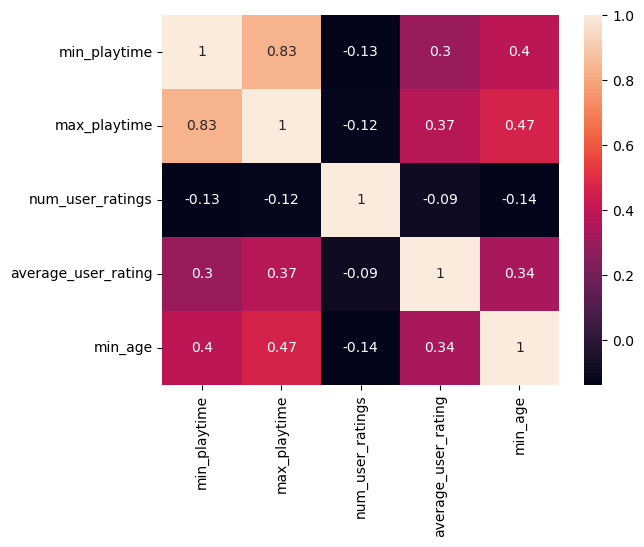

In [19]:
## No missing values remaining

## Now let's focus on the numeric fields, and generate a correlation matrix between them
NumFields = list(SimpleFields)
NumFields.remove('handle')
NumFields.remove('average_learning_complexity')
NumFields.remove('num_user_complexity_votes')
#convert min_age to float to enable correlation
Games_df['min_age'] = [float(i) for i in Games_df['min_age']]
sns.heatmap(Games_df[NumFields].corr(),annot=True)

The only fields with a reasonably strong correlation are min_playtime and max_playtime - as we might expect given that these are related.

We can see this in a scatter plot:

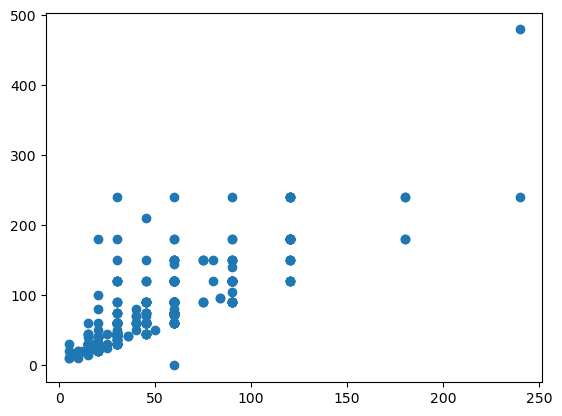

In [20]:
plt.scatter(x=Games_df['min_playtime'],y=Games_df['max_playtime'])

In [21]:
## To remove this correlation, let's replace min_playtime and max_playtime with a rough approximation
## of the average playtime, by taking the mean of the two
Games_df['playtime'] = Games_df[['min_playtime','max_playtime']].mean(axis=1)
Games_df = Games_df.drop(['min_playtime','max_playtime'],axis=1)

Now let's check the distribution of each of the numeric variables

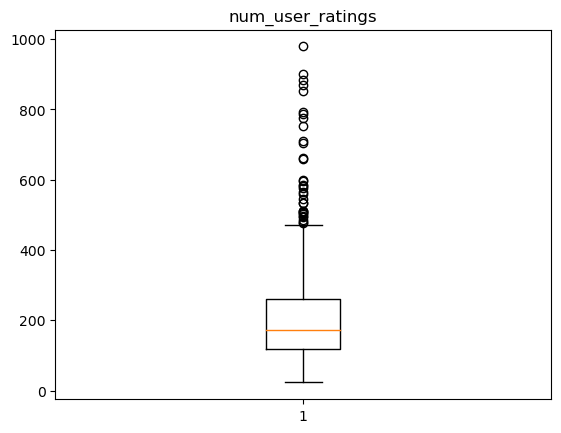

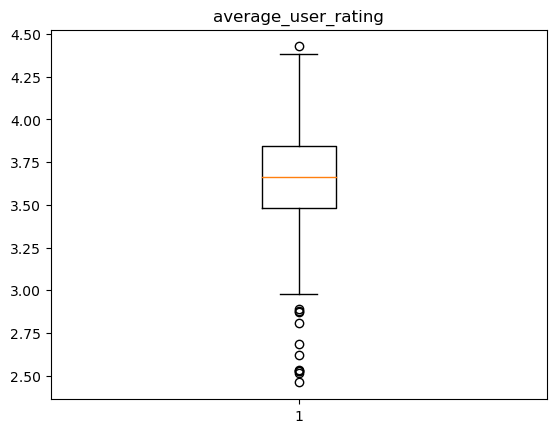

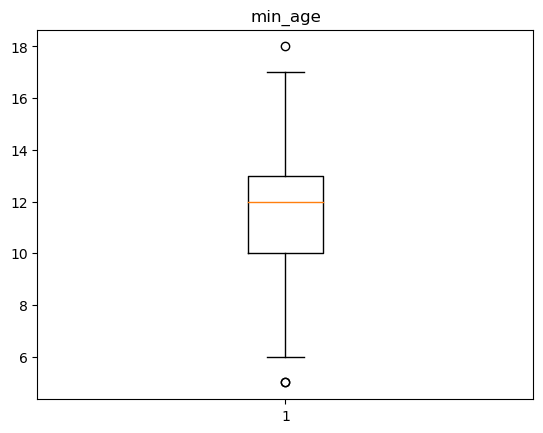

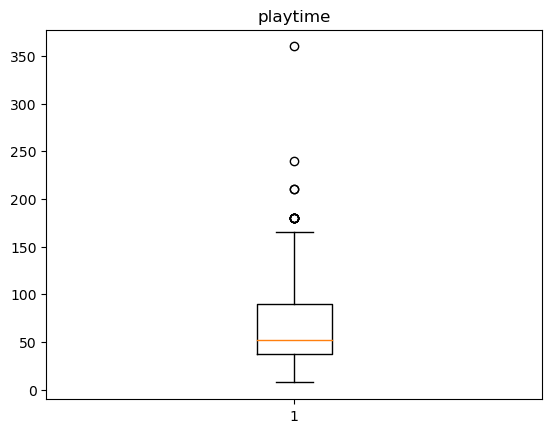

In [22]:
NumFields.remove('min_playtime')
NumFields.remove('max_playtime')
NumFields.append('playtime')
## Plot a boxplot for each field
for field in NumFields:
    plt.figure()
    plt.boxplot(Games_df[field])
    plt.title(field)

There are a few outliers in some fields - for example, a handful of games with a large number of ratings - but nothing that is likely to be problematic

One correlation from the correlation matrix stood out to me as particularly interesting: the modest correlation between playtime and user rating. Let's look at this using linear regression:

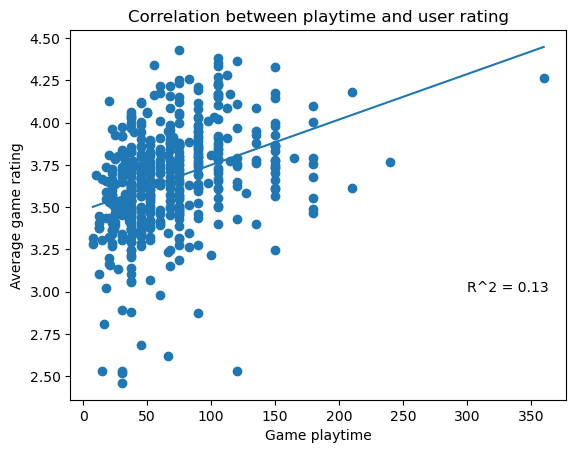

In [23]:
plt.scatter(x=Games_df['playtime'],y=Games_df['average_user_rating'])
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
model = LR.fit(Games_df['playtime'].values.reshape((-1,1)),Games_df['average_user_rating'].values)
## Add the regression line to the plot
lower = Games_df['playtime'].min()*model.coef_ + model.intercept_
upper = Games_df['playtime'].max()*model.coef_ + model.intercept_
plt.plot([Games_df['playtime'].min(),Games_df['playtime'].max()],
         [lower[0],upper[0]])
## display r-squared and p-value on plot
plt.text(300,3.0,'R^2 = ' +str(np.around(LR.score(Games_df['playtime'].values.reshape((-1,1)),Games_df['average_user_rating'].values),decimals=3)));

## Add labels to plot
plt.xlabel('Game playtime')
plt.ylabel('Average game rating')
plt.title('Correlation between playtime and user rating');

Indeed, there is a fairly weak correlation between the playtime of a game and its rating

In [24]:
## Let's change the game names to add capital letters and replace '-' with ' '
newnames = []
for name in Games_df['handle']:
    name = name.title().replace('-',' ')
    newnames.append(name)
Games_df['handle'] = newnames
    
## In the recommendation system, the user will input the name of a game,
## so we need to define a function to get the game index from its name
def get_index_from_name(name):
    idx = Games_df[Games_df["handle"]==name].index.tolist()[0]
    return Games_df.index.get_loc(idx)

## We want to return a description and image of the game, so let's make a list of the descriptions and image URLs
Game_Meta = {'Description':[],'Image_URL':[]}
Game_Meta = pd.DataFrame(Game_Meta)
## And a list of image URLs
for game in BoardGameList:
    Game_Meta.loc[game['id']] = [game['description_preview'],game['thumb_url']]

Game_Meta

,Description,Image_URL
TAAifFP590,Find adventure in this marvelous asymmetric g...,https://s3-us-west-1.amazonaws.com/5cc.images/...
yqR4PtpO8X,Scythe gives players almost complete contro...,https://cdn.shopify.com/s/files/1/0513/4077/15...
5H5JS0KLzK,"Wingspan is a competitive, medium-weight,...",https://s3-us-west-1.amazonaws.com/5cc.images/...
RLlDWHh7hR,Gloomhaven is a game of Euro-inspired tacti...,https://s3-us-west-1.amazonaws.com/5cc.images/...
fDn9rQjH9O,"In the 2400s, mankind begins to terraform the...",https://cdn.shopify.com/s/files/1/0513/4077/15...
...,...,...
OfW8SkMrMy,,https://s3-us-west-1.amazonaws.com/5cc.images/...
UXJOqsr0fE,"Neuroshima Hex! is a game of tactics, where...",https://s3-us-west-1.amazonaws.com/5cc.images/...
XZ1Wb2aYWr,Steam places you in control of a railway co...,https://s3-us-west-1.amazonaws.com/5cc.images/...
Oyfx6iH2n4,Nominated for the 2010 Spiel des Jahres awar...,https://s3-us-west-1.amazonaws.com/5cc.images/...


In [25]:
## Save Games_df and Game_Meta to .csv files
Games_df.to_csv('Games_df.csv')
Game_Meta.to_csv('Game_Meta.csv')

# Board Game Explorer
## Recommendation system

This system will take a game that a user likes and recommend similar games. To do so, it will take the data in Games_df and find the most similar games (using KNN).

## KNN model
Before building the KNN model, we need to select features and scale the data.

In [26]:
## Select features - remove name of game
NN_features = Games_df.drop('handle',axis=1)
## MinMax scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Scaled_features = scaler.fit_transform(NN_features)

Now we can build the model

In [30]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(Scaled_features)
distances,indices = nbrs.kneighbors(Scaled_features)

## Save nearest neighbors ('indices') to csv
knn_indices_df = pd.DataFrame(indices)
knn_indices_df.to_csv('knn_indices_df.csv')

## Recommendation app
We will create a small Dash app to make the recommendation system interactive.

In [35]:
## let's create a small app to make the recommendation system interactive:
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc
from dash.dependencies import Input, Output
import plotly.express as px
import sd_material_ui

# Build app
app = JupyterDash(__name__)

app.layout = html.Div([
    html.H1("Find new board games!"),
    html.Div([
        "Enter board game you already like: ",
        #Create a dropdown menu with the names of all board games in the database
        dcc.Dropdown(
            Games_df["handle"].values.tolist(), value='Root', id='my-input'),
        html.Div(id='dd-output-container')
    ]),
    html.Br(),
    html.Div(["We recommend: "]),
    #Return a table, each row with one recommendation
    #First column: game name and image; second column: game description
    html.Table([
            html.Tr([html.Div([html.Td(id='rec1',style={'font-weight':'bold'}),html.Img(id='img1',style={'height':'150px'})]),
                     html.Td(id='des1')]),
            html.Br(),
            html.Tr([html.Div([html.Td(id='rec2',style={'font-weight':'bold'}),html.Img(id='img2',style={'height':'150px'})]),
                     html.Td(id='des2')]),
            html.Br(),
            html.Tr([html.Div([html.Td(id='rec3',style={'font-weight':'bold'}),html.Img(id='img3',style={'height':'150px'})]),
                     html.Td(id='des3')]),
            html.Br(),
            html.Tr([html.Div([html.Td(id='rec4',style={'font-weight':'bold'}),html.Img(id='img4',style={'height':'150px'})]),
                     html.Td(id='des4')]),
            html.Br(),
            html.Tr([html.Div([html.Td(id='rec5',style={'font-weight':'bold'}),html.Img(id='img5',style={'height':'150px'})]),
                     html.Td(id='des5')]),
    ]),
])

# Define callback - 5 sets of outputs corresponding to the 5 recommendations
# Each set needs 3 outputs: the name, image URL and description of the recommended game
@app.callback(
    Output(component_id='rec1',component_property='children'),
    Output(component_id='img1',component_property='src'),
    Output(component_id='des1',component_property='children'),
    
    Output(component_id='rec2',component_property='children'),
    Output(component_id='img2',component_property='src'),
    Output(component_id='des2',component_property='children'),
    
    Output(component_id='rec3',component_property='children'),
    Output(component_id='img3',component_property='src'),
    Output(component_id='des3',component_property='children'),
    
    Output(component_id='rec4',component_property='children'),
    Output(component_id='img4',component_property='src'),
    Output(component_id='des4',component_property='children'),
    
    Output(component_id='rec5',component_property='children'),
    Output(component_id='img5',component_property='src'),
    Output(component_id='des5',component_property='children'),
    
    Input(component_id='my-input',component_property='value')
)

#for the output: gets the index of the input game, and present outputs from the recommendation system
#r = game name
#i = image URL
#u = game description
def update_output_div(input_game):
    game_id = get_index_from_name(input_game)
    # Exclude the first game (because this will be the game entered)
    # Get the ID of the recommended game, then return name, image URL and description of this game
    recID = Games_df.iloc[knn_indices_df[1][game_id]].name
    r1 = Games_df.loc[recID]['handle']
    i1 = Game_Meta.loc[recID]['Image_URL']
    d1 = Game_Meta.loc[recID]['Description']
    
    recID = Games_df.iloc[knn_indices_df[2][game_id]].name
    r2 = Games_df.loc[recID]['handle']
    i2 = Game_Meta.loc[recID]['Image_URL']
    d2 = Game_Meta.loc[recID]['Description']
    
    recID = Games_df.iloc[knn_indices_df[3][game_id]].name
    r3 = Games_df.loc[recID]['handle']
    i3 = Game_Meta.loc[recID]['Image_URL']
    d3 = Game_Meta.loc[recID]['Description']
    
    recID = Games_df.iloc[knn_indices_df[4][game_id]].name
    r4 = Games_df.loc[recID]['handle']
    i4 = Game_Meta.loc[recID]['Image_URL']
    d4 = Game_Meta.loc[recID]['Description']
    
    recID = Games_df.iloc[knn_indices_df[5][game_id]].name
    r5 = Games_df.loc[recID]['handle']
    i5 = Game_Meta.loc[recID]['Image_URL']
    d5 = Game_Meta.loc[recID]['Description']
    
    return r1,i1,d1,r2,i2,d2,r3,i3,d3,r4,i4,d4,r5,i5,d5



## Run the Board Game Explorer app

In [36]:
app.scripts.config.serve_locally = True
app.css.config.serve_locally = True
# Run app inline
app.run_server(mode='inline',port=8050,host="localhost",debug=True)